In [84]:
import os
import numpy as np
from matplotlib import ticker, dates as mdates, pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.objects import sensor
from pysar.utils import readfile, writefile, ptime, plot as pp
from pysar.simulation.plot import *


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pixelwise_geometry4dem_error'
sub_y = None

proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/PIXELWISE_GEOMETRY'
#sub_y = (400, 2400)
vlim = ((-60, 60), (-60, 60), (-5, 5))

proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/PIXELWISE_GEOMETRY'
sub_y = (800, 3700)
vlim = ((-90, 160), (-90, 160), (-10, 10))

proj_name = sensor.project_name2sensor_name(proj_dir)[1]
print('Project name: '+proj_name)

run_pysar_cmd = False
if run_pysar_cmd:
    os.chdir(proj_dir)
    print('Go to directory: '+proj_dir)

    # with pixelwise geometry
    cmd = 'dem_error.py timeseries_ECMWF.h5 -g ../INPUTS/geometryRadar.h5 -t pysarApp_template.txt'
    cmd += '\nmv demErr.h5 demErr_pixelGeom.h5'
    print(cmd)
    os.system(cmd)

    # with mean geometry
    cmd = 'dem_error.py timeseries_ECMWF.h5 -t pysarApp_template.txt'
    cmd += '\nmv demErr.h5 demErr_meanGeom.h5'
    cmd += '\ndiff.py demErr_pixelGeom.h5 demErr_meanGeom.h5 -o demErr_diffGeom.h5'
    print(cmd)
    os.system(cmd)

os.chdir(work_dir)
print('go to directory: '+work_dir)

Project name: GalapagosAlosAT133
go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pixelwise_geometry4dem_error


-66.42563 113.48153
-71.067406 108.377
-5.4890976 7.654175


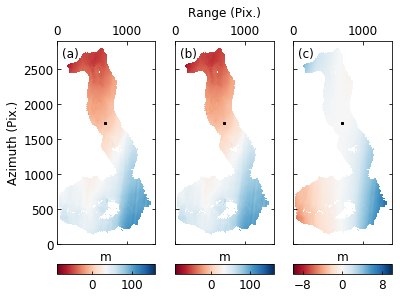

In [86]:
# plot

fnames = [os.path.join(proj_dir, i) for i in ['demErr_pixelGeom.h5',
                                              'demErr_meanGeom.h5',
                                              'demErr_diffGeom.h5']]
mask_file = os.path.join(proj_dir, 'maskTempCoh.h5')
atr = readfile.read_attribute(fnames[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
if not sub_y:
    box = (0, 0, width, length)
else:
    box = (0, sub_y[0], width, sub_y[1])

mask = readfile.read(mask_file, box=box)[0]
de_data = np.zeros((len(fnames), box[3]-box[1], box[2]-box[0]), np.float32)
for i in range(len(fnames)):
    data = readfile.read(fnames[i], box=box)[0]
    data[data == 0.] = np.nan
    data[mask == 0.] = np.nan
    de_data[i, :, :] = data
    print(np.nanmin(data), np.nanmax(data))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 5), sharex=True, sharey=True)
for i in range(len(fnames)):
    axi = ax[i]
    im = axi.imshow(de_data[i], cmap='RdBu', vmin=vlim[i][0], vmax=vlim[i][1])

    ref_y, ref_x = int(atr['REF_Y'])-box[1], int(atr['REF_X'])-box[0]
    axi.plot(ref_x, ref_y, 'sk', ms=2)
    if atr['ORBIT_DIRECTION'].lower().startswith('desc'):
        axi.invert_xaxis()
    else:
        axi.invert_yaxis()
    axi.xaxis.tick_top()
    axi.tick_params(which='both', direction='in', labelsize=font_size,
                    bottom=True, top=True, left=True, right=True)

    # colorbar
    divider = make_axes_locatable(axi)
    cax = divider.append_axes("bottom", "5%", pad="10%")
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.locator = ticker.MaxNLocator(nbins=3)
    cbar.update_ticks()
    cbar.set_label('m', fontsize=font_size)
    cbar.ax.xaxis.set_label_position('top')
    cax.tick_params(direction='in', labelsize=font_size)

    num_labels = ['(a)', '(b)', '(c)']
    axi.annotate(num_labels[i], xy=(0.05, 0.92), xycoords='axes fraction', fontsize=font_size)  #0.90, 0.92

pp.set_shared_xlabel(ax, 'Range (Pix.)', labelpad=0.16)  #0.08, 0.16
pp.set_shared_ylabel(ax, 'Azimuth (Pix.)', labelpad=-0.04)

out_file = 'pixel_geom4dem_{}.jpg'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', dpi=fig_dpi)
plt.show()